In [2]:
import rosbag
import utm
from collections import deque
import pymap3d as pm
from sensor_msgs.msg import NavSatFix, Imu
from std_msgs.msg import Header
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import plotly.express as px
from geo_transforms import *
%matplotlib inline

### Import data from the ROSBAG, and add to a pandas data frame

In [3]:
bag_path = 'bag2.bag'
gps_topic = '/gps/fix'
imu_topic = '/imu/imu_uncompensated'

# Lists to store data
gps_timestamps = []
latitude_list = []
longitude_list = []
altitude_list = []

imu_timestamps = []
linear_acceleration_x = []
linear_acceleration_y = []
linear_acceleration_z = []
angular_velocity_x = []
angular_velocity_y = []
angular_velocity_z = []
orientation_x = []
orientation_y = []
orientation_z = []
orientation_w = []

# Open the bag file
with rosbag.Bag(bag_path, 'r') as bag:
    # Iterate through messages and process GPS and IMU data
    for topic, msg, t in bag.read_messages(topics=[gps_topic, imu_topic]):
        if topic == gps_topic and msg._type == 'sensor_msgs/NavSatFix':
            # Process GPS data
            gps_timestamps.append(msg.header.stamp.to_sec())
            latitude_list.append(msg.latitude)
            longitude_list.append(msg.longitude)
            altitude_list.append(msg.altitude)

        elif topic == imu_topic and msg._type == 'sensor_msgs/Imu':
            # Process IMU data
            imu_timestamps.append(msg.header.stamp.to_sec())
            linear_acceleration_x.append(msg.linear_acceleration.x)
            linear_acceleration_y.append(msg.linear_acceleration.y)
            linear_acceleration_z.append(msg.linear_acceleration.z)
            angular_velocity_x.append(msg.angular_velocity.x)
            angular_velocity_y.append(msg.angular_velocity.y)
            angular_velocity_z.append(msg.angular_velocity.z)
            orientation_x.append(msg.orientation.x)
            orientation_y.append(msg.orientation.y)
            orientation_z.append(msg.orientation.z)
            orientation_w.append(msg.orientation.w)

# Create separate Pandas DataFrames for GPS and IMU data
gps_df = pd.DataFrame({
    'Timestamp': gps_timestamps,
    'Latitude': latitude_list,
    'Longitude': longitude_list,
    'Altitude': altitude_list,
})

imu_df = pd.DataFrame({
    'Timestamp': imu_timestamps,
    'LinearAccelerationX': linear_acceleration_x,
    'LinearAccelerationY': linear_acceleration_y,
    'LinearAccelerationZ': linear_acceleration_z,
    'AngularVelocityX': angular_velocity_x,
    'AngularVelocityY': angular_velocity_y,
    'AngularVelocityZ': angular_velocity_z,
    'OrientationX': orientation_x,
    'OrientationY': orientation_y,
    'OrientationZ': orientation_z,
    'OrientationW': orientation_w
})

#Save the DataFrames to CSV files
gps_df.to_csv('gps_data.csv', index=False)
imu_df.to_csv('imu_data.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'bag2.bag'

### GPS Map

In [4]:
# Load GPS data from the CSV file
gps_df = pd.read_csv('gps_data.csv')

# Create a scatter plot for latitude and longitude
fig = px.scatter_mapbox(
    gps_df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Timestamp',
    zoom=10,
)

# Set the map style
fig.update_layout(
    mapbox_style="open-street-map",
    margin=dict(l=0, r=0, t=0, b=0),
)

# Show the plot
fig.show()


In [5]:
gps_data = pd.read_csv('gps_data.csv')
gps_data.dropna(inplace=True)

### Convert GPS latlon to Easting, Northing

In [6]:
# Set the reference coordinates
ref_lat = gps_data['Latitude'].iloc[0]
ref_lon = gps_data['Longitude'].iloc[0]
ref_alt = gps_data['Altitude'].iloc[0]

# Convert coordinates to ENU
enu_coordinates = gps_data.apply(lambda row: pm.geodetic2enu(
    row['Latitude'],
    row['Longitude'],
    row['Altitude'],
    ref_lat,
    ref_lon,
    ref_alt
), axis=1)

# Add ENU coordinates to the dataframe
gps_data['East'], gps_data['North'], gps_data['Up'] = zip(*enu_coordinates)


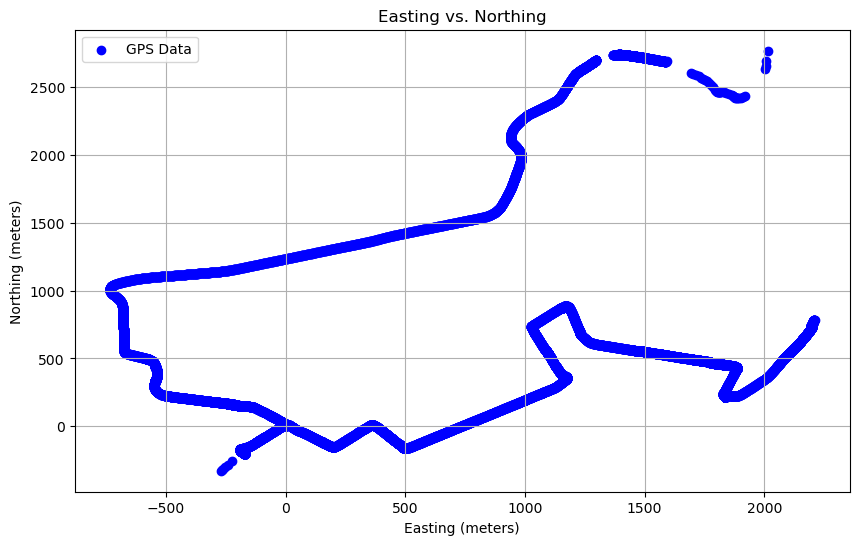

In [7]:
# Plot Easting and Northing
plt.figure(figsize=(10, 6))
plt.scatter(gps_data['East'], gps_data['North'], marker='o', color='b', label='GPS Data')
plt.title('Easting vs. Northing')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')
plt.legend()
plt.grid(True)
plt.show()

### Calculate the Turning Angle from the gps measurements

In [8]:
# Extract relevant columns
gps_coordinates = gps_data[['East', 'North']].values
num_points = len(gps_coordinates)

# Calculate vectors between consecutive points
vectors = gps_coordinates[1:] - gps_coordinates[:-1]

# Calculate angles between consecutive vectors
angles = np.arctan2(vectors[:, 1], vectors[:, 0])

# Add turning angles as a new column
turning_angles = np.insert(angles, 0, 0)  # Insert 0 for the first point
gps_data['Turning_Angle'] = turning_angles


### Remove the Bias from the IMU measurements

(24001, 7)


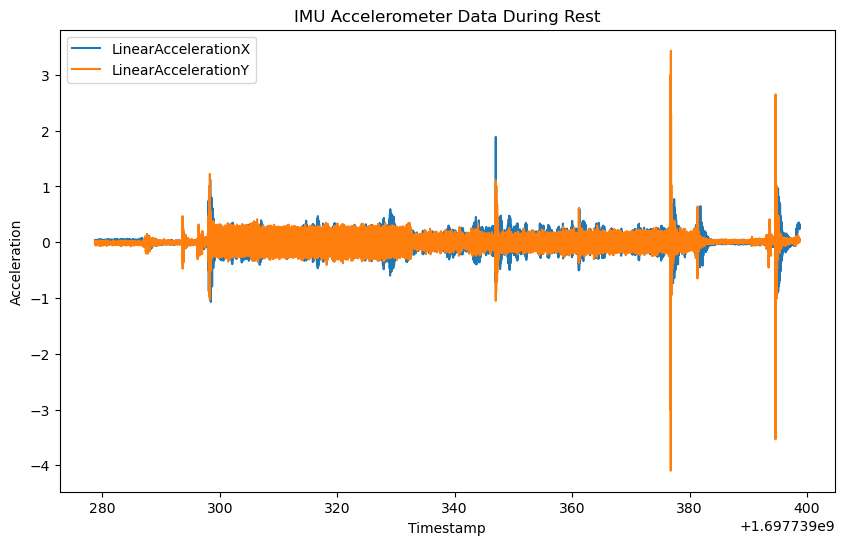

In [9]:
rest_duration_sec = 120
sample_freq_hz = 199.96 # Hz
imu_data = pd.read_csv('imu_data.csv')
imu_data.drop(columns= ['LinearAccelerationZ', 'AngularVelocityX', 'AngularVelocityY', 'OrientationX', 'OrientationY', 'OrientationZ', 'OrientationW'], inplace=True)

# Calculate the number of samples for bias estimation during rest
num_bias_samples = int(rest_duration_sec * sample_freq_hz)

# Extract relevant columns for bias estimation
bias_estimation_data = imu_data.iloc[:num_bias_samples, 1:]

# Estimate biases during rest
linear_acceleration_bias = bias_estimation_data[['LinearAccelerationX', 'LinearAccelerationY']].mean().values
angular_velocity_bias = bias_estimation_data[['AngularVelocityZ']].mean().values

# Apply bias correction to the remaining data
imu_data['processed_linear_acceleration_x'] = imu_data['LinearAccelerationX'] - linear_acceleration_bias[0]
imu_data['processed_linear_acceleration_y'] = imu_data['LinearAccelerationY'] - linear_acceleration_bias[1]

imu_data['processed_angular_velocity_z'] = imu_data['AngularVelocityZ'] - angular_velocity_bias

# Create the processed DataFrame
processed_data_df = imu_data[['Timestamp', 'processed_linear_acceleration_x', 'processed_linear_acceleration_y', 'processed_angular_velocity_z']]

# Assuming imu_data is your DataFrame
rest_start_time = imu_data['Timestamp'].iloc[0]
rest_end_time = rest_start_time + rest_duration_sec

# Filter the DataFrame for the rest period
rest_data = imu_data[(imu_data['Timestamp'] >= rest_start_time) & (imu_data['Timestamp'] <= rest_end_time)]
print(rest_data.shape)
# Plot LinearAccelerationX and LinearAccelerationY
plt.figure(figsize=(10, 6))
plt.plot(rest_data['Timestamp'], rest_data['processed_linear_acceleration_x'], label='LinearAccelerationX')
plt.plot(rest_data['Timestamp'], rest_data['processed_linear_acceleration_y'], label='LinearAccelerationY')

plt.title('IMU Accelerometer Data During Rest')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration')
plt.legend()
plt.show()


## Prediction Step
### calculate the predicted mean and covariance matrix

$$ \text{Predicted State Estimate:} \quad \hat{X}^- = F \cdot \hat{X} $$
$$ \text{Predicted Covariance Estimate:} \quad P^- = F \cdot P \cdot F^T + Q $$


In [10]:
def prediction(x_hat, P, dt):

    # State transition matrix
    F = np.array(
    [[1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2, 0.0],     # x
    [0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0, 0.5*dt**2],      # y
    [0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0, 0.0],            # θ
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt, 0.0],            # v_x
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, dt],            # v_y
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],           # theta_dot
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],           # a_x
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])          # a_y

    # Control input matrix (assuming no control input in this example)
    B = np.array([[0], [0], [0], [0], [0], [0], [0], [0]])

    # Control input (assuming no control input in this example)
    u_k = np.array([0])

    # Prediction step
    x_hat_ = np.dot(F, x_hat)  # + np.dot(B, u_k) 

    # Process noise covariance matrix
    Q = np.diag([0.1]*8)

    # Covariance prediction
    P_ = np.dot(np.dot(F, P), F.T) + Q

    return x_hat_, P_


## Correction Step

The correction step of the Kalman filter is responsible for updating the predicted state estimate based on the actual measurement.


In [18]:
def correction(x_hat_minus, P_minus, measurement):
    """
    Correction step of the Kalman Filter.'

    Parameters:
    - x_hat_minus: Predicted state estimate at time k (numpy array)
    - K: Kalman Gain (numpy array)
    - measurement: Measurement at time k (numpy array)

    Returns:
    - Corrected state estimate at time k (numpy array)
    """
    H = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0]]) # Measurement matrix, assuming direct observation of x and y

    sigma_gps = 1  # Adjust based on the accuracy of your GPS
    R = np.diag([sigma_gps**2, sigma_gps**2])
        
    # Calculate the innovation (residual)
    innovation = measurement - np.dot(H, x_hat_minus)
    
    # Calculate the innovation covariance
    S = np.dot(np.dot(H, P_minus), H.T) + R
    
    # Calculate the Kalman Gain
    K = np.dot(np.dot(P_minus, H.T), np.linalg.inv(S))
    
    # Correct the state estimate    
    x_hat = x_hat_minus + np.dot(K, innovation)
    
    # Correct the covariance matrix
    P = P_minus - np.dot(np.dot(K, H), P_minus)
    
    return x_hat, K, P 


### Initialize the state and covariance

In [19]:
# Initial state vector [x, y, theta, x_dot, y_dot, theta_dot]
x_hat_initial = np.zeros((8, 1))

# Initial covariance matrix
sigma_x_0 = 1  # Adjust based on your estimation of the initial uncertainty
sigma_y_0 = 1
sigma_theta_0 = 1
sigma_dot_x_0 = 1
sigma_dot_y_0 = 1
sigma_dot_theta_0 = .1
sigma_dot_dot_x = .1
sigma_dot_dot_y = .1

P_initial = np.diag([sigma_x_0**2, sigma_y_0**2, sigma_theta_0**2, 
             sigma_dot_x_0**2, sigma_dot_y_0**2, sigma_dot_theta_0**2
             ,sigma_dot_dot_x**2, sigma_dot_dot_y**2])

# Extract values from DataFrame columns to NumPy arrays for faster access
gps_timestamp = gps_data['Timestamp'].values
imu_timestamp = imu_data['Timestamp'].values
gps_east = gps_data['East'].values
gps_north = gps_data['North'].values
imu_linear_accel_x = imu_data['processed_linear_acceleration_x'].values
imu_linear_accel_y = imu_data['processed_linear_acceleration_y'].values
imu_angular_velocity_z = imu_data['processed_angular_velocity_z'].values

### Run the Main Kalman Filter Routine

In [30]:
# Lists to store filtered results
x_filtered = []
y_filtered = []

# Initialize indices for IMU and GPS data
imu_index = 0
gps_index = 0

# Main Kalman filter routine
while imu_index < len(imu_timestamp) and gps_index < len(gps_timestamp):
    # Prediction step using IMU data
    if imu_timestamp[imu_index] < gps_timestamp[gps_index]:
        dt = imu_timestamp[imu_index + 1] - imu_timestamp[imu_index] if imu_index + 1 < len(imu_timestamp) else 0.005
        
        # Use initial estimates for the first iteration
        if imu_index == 0:
            x_hat_[5] = imu_angular_velocity_z[0]
            x_hat_[6] = imu_linear_accel_x[0]
            x_hat_[7] = imu_linear_accel_y[0]
            x_hat_, P_ = prediction(x_hat_initial, P_initial, dt)
        else:
            x_hat_[5] = imu_angular_velocity_z[imu_index]
            x_hat_[6] = imu_linear_accel_x[imu_index]
            x_hat_[7] = imu_linear_accel_y[imu_index]
            x_hat_, P_ = prediction(x_hat_, P_, dt)
    
            # Append results from prediction step
            x_filtered.append(x_hat_[0])
            y_filtered.append(x_hat_[1])

        imu_index += 1
    # Correction step using GPS data
    else:
        measurement = np.array([gps_east[gps_index], gps_north[gps_index]]).reshape((2, 1))
        x_hat, _, P = correction(x_hat_, P_, measurement)

        # Append results from correction step
        x_filtered.append(x_hat[0])
        y_filtered.append(x_hat[1])

        gps_index += 1

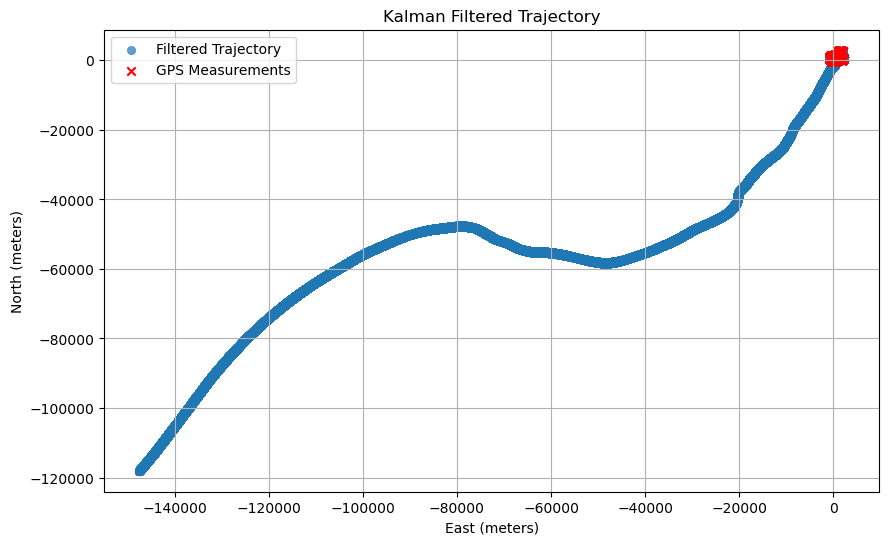

In [26]:
# Plotting results
plt.figure(figsize=(10, 6))
plt.scatter(x_filtered, y_filtered, label='Filtered Trajectory', marker='o', linewidth=0.5, alpha=0.7)
plt.scatter(gps_east, gps_north, color='red', label='GPS Measurements', marker='x')
plt.title('Kalman Filtered Trajectory')
plt.xlabel('East (meters)')
plt.ylabel('North (meters)')
plt.legend()
plt.grid(True)
plt.show()

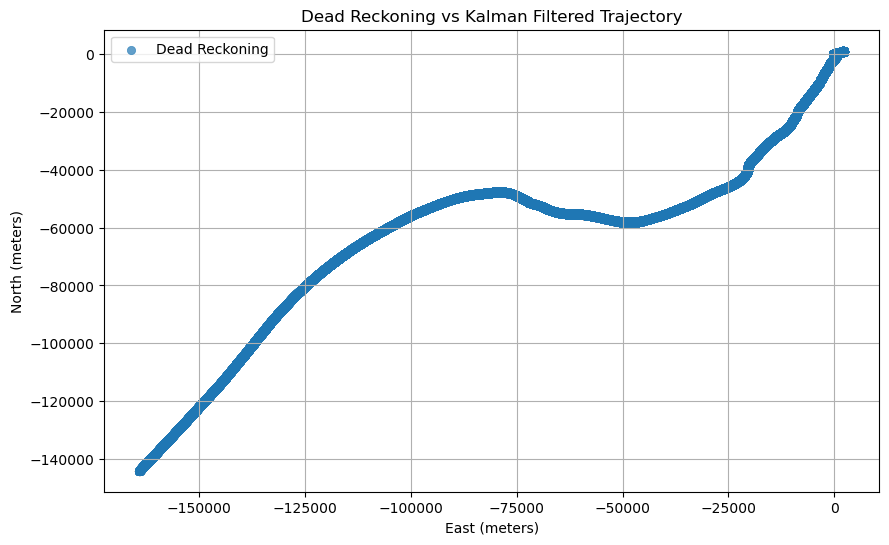

In [16]:
# Lists to store dead reckoning results
x_dead_reckoning = [0]  # Assuming the initial position is at the origin
y_dead_reckoning = [0]

# Initialize velocities
vx = 0
vy = 0

# Main Dead Reckoning routine using IMU data
for i in range(1, len(imu_timestamp)):
    dt_imu = imu_timestamp[i] - imu_timestamp[i - 1]

    # Prediction step using IMU data
    x_hat[5] = imu_angular_velocity_z[i - 1]
    x_hat[6] = imu_linear_accel_x[i - 1]
    x_hat[7] = imu_linear_accel_y[i - 1]
    x_hat, _ = prediction(x_hat, P, dt_imu)

    # Integrate linear accelerations to estimate velocity
    vx += imu_linear_accel_x[i - 1] * dt_imu
    vy += imu_linear_accel_y[i - 1] * dt_imu

    # Integrate velocity to estimate position
    x_dead_reckoning.append(x_dead_reckoning[-1] + vx * dt_imu)
    y_dead_reckoning.append(y_dead_reckoning[-1] + vy * dt_imu)

# Plotting results
plt.figure(figsize=(10, 6))
plt.scatter(x_dead_reckoning, y_dead_reckoning, label='Dead Reckoning (IMU Only)', marker='o', linewidth=0.5, alpha=0.7)
plt.title('Dead Reckoning (IMU Only)')
plt.xlabel('East (meters)')
plt.ylabel('North (meters)')
plt.legend()
plt.grid(True)
plt.show()

### Kalman FIlter Predicted Estimates

As you can see the kalman filtered trajectory is not, performing well, I think it is because of the co-ordinate system alignment, I have tried some techniques but wasn't able to figure out how to, get proper estimates, can you comment on what else is going Wrong here?,
also as you can see in the above code, the dead reckoned estimates accumulate a large amout of drift hance, we have to use gps along with the imu to keep check on the accumulated drift